### Notes on Prophet

In the first part I briefly walk through the prophet code base, highlighting key computation steps. Second part is a small demo of how to extract preprocessed data from prophet, fit it using another mcmc library (numpyro) and then put estimated parameters back into prophet for prediction. The purpose is to demonstrate the modeling logic, not to reproduce prophet perfectly.

#### Why?

This is not supposed to be a tutorial or a guide, but patchy notes for myself to quickly recall how prophet works. 

#### Acknowledgements

My main inspiration has been this excellent post [1] from Ritchie Vink (creator of polars). I heavily borrowed from Nicolas Fauchereau's notebook [2] on alaysis of weather impact on cycling counts in Auckland, and used the same data. Finally, I thank developers of prophet [3]. Docs are helpful and code is easy to navigate. 


1. [Build Facebook's Prophet in PyMC3; Bayesian time series analyis with Generalized Additive Models](https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/)
2. [The impact of weather conditions on cycling counts in Auckland, New Zealand](#https://github.com/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb)
3. https://github.com/facebook/prophet/tree/main

### Contents

Part I  
1. [Preprocessing & Feature Construction](#1-preprocessing--feature-construction)  
    * [1.1 Scaling](#11-scaling)  
    * [1.2 Seasonality](#12-seasonality)  
    * [1.3 Holidays](#13-holidays)  
    * [1.4 Regressor Matrix](#14-regressor-matrix)  
    * [1.5 Changepints](#15-changepoints)  
2. [Fitting](#2-fitting)  
    * [2.1 Model Variables](#21-model-variables)  
3. [Prediction](#3-prediction)  
    * [3.1 Preprocessing](#31-preprocessing)  
    * [3.2 Prediction Components](#32-prediction-components)  
    * [3.3 Trend](#33-trend)  
    * [3.4 Seasonalities](#34-seasonalities)  
    * [3.5 Putting All Together](#35-putting-all-together)  
4. [Uncertainty](#4-uncertainty)  
    * [4.1 Overview](#41-overview)  
    * [4.2 Trend Uncertainty](#42-trend-uncertainty)  
    * [4.3 Seasonality Uncertainty](#43-seasonality-uncertainty)  
  
Part II
1. [Setup](#1-setup)
2. [Data Wrangling](#2-data-wrangling)
3. [Fitting](#3-fitting)
4. [Forecasting](#4-forecasting)
5. [Variable Extraction](#5-variable-extraction)
6. [Numpyro Model Specification](#6-numpyro-model-specification)
7. [Model Fitting](#7-model-fitting)
8. [Prophet/Numpyro Param Comparison](#8-prophetnumpyro-param-comparison)
9. [Forecasts Comparison](#9-forecasts-comparison)
10. [Discussion](#discussion)
  

### Part I

### 1 Preprocessing & Feature Construction

[[To the top]](#contents)

#### 1.1 Scaling

Time is scaled to [0, 1] range:

```python
df['t'] = (df['ds'] - self.start) / self.t_scale
```

If `self.scaling\=="abs_max"`, then target series is scaled to [0, 1] range:

```python
df['y_scaled'] = (df['y'] - df['floor']) / self.y_scale
```

External regressors are standardized

```python
for name, props in self.extra_regressors.items():
    df[name] = ((df[name] - props['mu']) / props['std'])
```

#### 1.2 Seasonality
They use what they call "Fourier components" (not Fourier coefficients): sine and cosine of unix time, converted to days, for each seasonality (yearly, weekly, daily). `series_order` specifies number of frequencies. Resulting shape is `(dates.shape[0], 2 * series_order)`

```python
# convert to days since epoch
t = dates.to_numpy(dtype=np.int64) // NANOSECONDS_TO_SECONDS / (3600 * 24.)

x_T = t * np.pi * 2
fourier_components = np.empty((dates.shape[0], 2 * series_order))
for i in range(series_order):
    c = x_T * (i + 1) / period
    fourier_components[:, 2 * i] = np.sin(c)
    fourier_components[:, (2 * i) + 1] = np.cos(c)
return fourier_components
```

#### 1.3 Holidays

Holiday features are binary indicators (for example in a dataframe with one year of hourly data there will be 24 consecutive ones for each annual holiday)

```python
if loc is not None:
	expanded_holidays[key][loc] = 1.
# ...

holiday_features = pd.DataFrame(expanded_holidays)
```

#### 1.4 Regressor Matrix
`regressor_column_matrix(self, seasonal_features, modes)` builds regressor matrix. 

```python
components = pd.DataFrame({
            'col': np.arange(seasonal_features.shape[1]),
            'component': [
                x.split('_delim_')[0] for x in seasonal_features.columns
            ],
        })
```

`components` is just a table of feature names and their indices within a dataframe.
Few more "component groups" are added to `components`: holidays group, multiplicative factor group, additive factor group. For example, 
- if a 10-th column feature is a holiday with mode="multiplicative", `components` would include rows (10, "New Year"), (10, "Holidays") and (10, "multiplicative_terms"); 
- if 5-th column feature is an external regressor with mode="additive", `components` would include rows (5, "regressor_1"), (5, "extra_regressors_additive");

The resulting matrix is obtained via `pd.crosstab`, which works like this:

```python
>>> foo = pd.Categorical(['a', 'b'], categories=['a', 'b', 'c'])
>>> bar = pd.Categorical(['d', 'e'], categories=['d', 'e', 'f'])
>>> pd.crosstab(foo, bar)
col_0  d  e
row_0
a      1  0
b      0  1
>>> pd.crosstab(foo, bar, dropna=False)
col_0  d  e  f
row_0
a      1  0  0
b      0  1  0
c      0  0  0
```

So in the end we have a matrix where each row has ones for the relevant linear model coefficients: a 10-th feature would have ones in columns "New Year", "Holidays" and "Multiplicative Terms".

#### 1.5 Changepoints
Changepoints are spread evenly across first `int(np.floor(self.history.shape[0] * self.changepoint_range))` timesteps:

```python
cp_indexes = (
                np.linspace(0, hist_size - 1, self.n_changepoints + 1)
                  .round()
                  .astype(int)
)
self.changepoints = (
                    self.history.iloc[cp_indexes]['ds'].tail(-1)
)
```

### 2 Fitting

[[To the top]](#contents)

prophet uses Stan backend for inference. Stan model is specified using its own probabilistic language in a file with .stan extension (in our case it's [prophet.stan](https://github.com/facebook/prophet/blob/main/python/stan/prophet.stan)). Model file describes input and intermediate variables, data transformations, parameters to sample and the log likelihood function to optimize.     

```python
self.params = self.stan_backend.sampling(stan_init, dat, self.mcmc_samples, **kwargs)
```

Here `dat` is a dict of model variables, and `stan_init` is a dict of parameters' initial values, discussed below.

#### 2.1 Model Variables

Here's the mapping between input data and mcmc model variables (parameters, constants and input data), as defined in prophet.stan.

```python
model_inputs = self.preprocess(df, **kwargs)
# ...

return ModelInputData(
            T=self.history.shape[0],
            S=len(self.changepoints_t),
            K=seasonal_features.shape[1],
            tau=self.changepoint_prior_scale,
            trend_indicator=TrendIndicator[self.growth.upper()].value,
            y=self.history['y_scaled'],
            t=self.history['t'],
            t_change=self.changepoints_t,
            X=seasonal_features,
            sigmas=prior_scales,
            s_a=component_cols['additive_terms'],
            s_m=component_cols['multiplicative_terms'],
            cap=cap,
        )
```

#### 2.2 Initial Values

```python
initial_params = self.calculate_initial_params(model_inputs.K)
# ...

if self.growth == 'linear':
    k, m = self.linear_growth_init(self.history)
elif self.growth == 'flat':
    k, m = self.flat_growth_init(self.history)
elif self.growth == 'logistic':
    k, m = self.logistic_growth_init(self.history)
return ModelParams(
    k=k,
    m=m,
    delta=np.zeros_like(self.changepoints_t),
    beta=np.zeros(num_total_regressors),
    sigma_obs=1.0,
)
```
For the case of linear growth a line is drawn through y_0 and y_n. Its slope and bias characterize initial linear growth. Note, it's not a best-fit line, but a line, connecting first and last time series values.

```python
i0, i1 = df['ds'].idxmin(), df['ds'].idxmax()
T = df['t'].iloc[i1] - df['t'].iloc[i0]
k = (df['y_scaled'].iloc[i1] - df['y_scaled'].iloc[i0]) / T
m = df['y_scaled'].iloc[i0] - k * df['t'].iloc[i0]
return (k, m)
```

### 3 Prediction

[[To the top]](#contents)

#### 3.1 Preprocessing 

At prediction time input dataframe is preprocessed/featurized in the same way as during training: 
- time is scaled to range (1, $\inf$)
- external regressors are standardized using means and stds, estimated at train time
- seasonal and holiday features are calcluated from datetime index
- regressor matrix is constructed 

#### 3.2 Prediction Components

Prophet is an additive model, composed of trend, seasonal and holiday components. All components are predicted separately, recorded as separate columns and then combined.

```python
df['trend'] = self.predict_trend(df)
seasonal_components = self.predict_seasonal_components(df)
# ...

# Add in forecast components
df2 = pd.concat((df[cols], intervals, seasonal_components), axis=1)
df2['yhat'] = (
                df2['trend'] * (1 + df2['multiplicative_terms'])
                + df2['additive_terms']
)
return df2
```
#### 3.3 Trend

Trend might be piecewise linear or piecewise sigmoidal with slopes and biases changing at changepoints. Here's the linear case. Sample parameters (slopes, biases and deltas), produced by mcmc, are averaged to get a point estimate.

```python
k = np.nanmean(self.params['k'])
m = np.nanmean(self.params['m'])
deltas = np.nanmean(self.params['delta'], axis=0)

trend = self.piecewise_linear(t, deltas, k, m, self.changepoints_t)

# ...

deltas_t = (changepoint_ts[None, :] <= t[..., None]) * deltas
k_t = deltas_t.sum(axis=1) + k
m_t = (deltas_t * -changepoint_ts).sum(axis=1) + m
return k_t * t + m_t

# ...

return trend * self.y_scale + df['floor']
```

#### 3.4 Seasonalities 

Seasonal components (including holidays). 

This is essentially a matrix multiplication. Multiplicative components aren't scaled by `self.y_scale`, because they themselves act as scalers for trend. 

```python
X = seasonal_features.values
data = {}
for component in component_cols.columns:
    beta_c = self.params['beta'] * component_cols[component].values

    comp = np.matmul(X, beta_c.transpose())
    if component in self.component_modes['additive']:
        comp *= self.y_scale
    data[component] = np.nanmean(comp, axis=1)
    if self.uncertainty_samples:
        data[component + '_lower'] = self.percentile(
                    comp, lower_p, axis=1,
        )
        data[component + '_upper'] = self.percentile(
                    comp, upper_p, axis=1,
        )
return pd.DataFrame(data)
```

Note,`component_cols.sum(axis=1)` has all entries greater than one, implying that beta coefficients for the same column would be added multiple times (why?) 

#### 3.5 Putting All Together

```python
cols = ['ds', 'trend']
if 'cap' in df:
    cols.append('cap')
if self.logistic_floor:
    cols.append('floor')
# Add in forecast components
df2 = pd.concat((df[cols], intervals, seasonal_components), axis=1)
df2['yhat'] = (
                df2['trend'] * (1 + df2['multiplicative_terms'])
                + df2['additive_terms']
)
return df2
```

The final predicted value `yhat` is a sum of trend, additive terms and the product of trend and multiplicative terms. 

### 4 Uncertainty

[[To the top]](#contents)

#### 4.1 Overview 

Prophet uses mcmc stan backend to estimate model parameters. Mcmc produces specified number of samples (600 by default), which we can aggregate in various ways, eg compute quantiles and plot confidence intervals.

#### 4.2 Trend Uncertainty 

First, expected value is computed as before

```python
deltas = self.params["delta"][iteration]
m = self.params["m"][iteration]
k = self.params["k"][iteration]
if self.growth == "linear":

expected = self.piecewise_linear(df["t"].values, deltas, k, m, self.changepoints_t)
```

Interval estimate appears more complicated.

```python
    def _make_trend_shift_matrix(
        mean_delta: float, likelihood: float, future_length: float, n_samples: int
    ) -> np.ndarray:
        """
        Creates a matrix of random trend shifts based on historical likelihood and size of shifts.
        Can be used for either linear or logistic trend shifts.
        Each row represents a different sample of a possible future, and each column is a time step into the future.
        """
        # create a bool matrix of where these trend shifts should go
        bool_slope_change = np.random.uniform(size=(n_samples, future_length)) < likelihood
        shift_values = np.random.laplace(0, mean_delta, size=bool_slope_change.shape)
        mat = shift_values * bool_slope_change
        n_mat = np.hstack([np.zeros((len(mat), 1)), mat])[:, :-1]
        mat = (n_mat + mat) / 2
        return mat
```

`change_likelihood` is the probability of a changepoint occuring at any given point in time

```python
single_diff = np.diff(future_df["t"]).mean()
# ...
change_likelihood = len(self.changepoints_t) * single_diff
```

Since time is scaled to [0, 1] interval, this is just:  

$\frac{n_{changepoints}}{n_{timesteps}} = \frac{n_{changepoints}}{1 / dt} = n_{changepoints} * dt$

Then we sample `future_length` samples from $Bernoulli(change\_likelihood)$ 

`bool_slope_change = np.random.uniform(size=(n_samples, future_length)) < likelihood`

Magnitudes of changes are sampled from $Laplace(0, mean\_delta)$, where mean_delta is a sample average of deltas, obtained during training (from mcmc).

This code I don't get. It splits each change in two equal consecutive changes. Why? Those changes would be accumulated later so the only difference it makes is to make transition more gradual.

```python
n_mat = np.hstack([np.zeros((len(mat), 1)), mat])[:, :-1]
mat = (n_mat + mat) / 2
```

Slope changes are then accumulated twice to get actual values (first summation to get slope values from slope changes; second to get level values from slopes) and multiplied by $dt$ to get proper scale.

```python
if self.growth == "linear":
    mat = self._make_trend_shift_matrix(mean_delta, change_likelihood, n_length, n_samples=n_samples)
    uncertainties = mat.cumsum(axis=1).cumsum(axis=1)  # from slope changes to actual values
    uncertainties *= single_diff  # scaled by the actual meaning of the slope
```

Expected value is added to expected change

```python
return (
    (np.tile(expected, (n_samples, 1)) + uncertainty) * self.y_scale +
    np.tile(df["floor"].values, (n_samples, 1))
)
```

This was a trend. Now we add separate Normal(0, sigma) noise to it.  

```python
trends = self.sample_predictive_trend_vectorized(df, n_samples, iteration) # already on the same scale as the actual data

sigma = self.params['sigma_obs'][iteration]
noise_terms = np.random.normal(0, sigma, trends.shape) * self.y_scale
```

```python
simulations = []
for trend, noise in zip(trends, noise_terms):

	simulations.append({
	'yhat': trend * (1 + Xb_m) + Xb_a + noise,
	'trend': trend
})
return simulations
```

This is a single simulation, which corresponds to a single mcmc sample (called `iteration` in the code). In total there would be *at least* `self.uncertainty_samples` of samples. Each simulation generates `samp_per_iter` samples 

```python
n_iterations = self.params['k'].shape[0]
samp_per_iter = max(1, int(np.ceil(
self.uncertainty_samples / float(n_iterations)
)))
```

"at least" because they get ceiling, so for self.uncertainty_samples=1000 (by default) and n_samples=600 (by default) samp_per_iter would be 2 and total number of uncertainty samples 600 x 2 = 1200.

From those samples quantiles are then calculated to get confidence interval (`yhat_lower`, `yhat_upper`)

```python
sim_values = self.sample_posterior_predictive(df, vectorized)

lower_p = 100 * (1.0 - self.interval_width) / 2
upper_p = 100 * (1.0 + self.interval_width) / 2

series = {}
for key in ['yhat', 'trend']:

	series['{}_lower'.format(key)] = self.percentile(
	sim_values[key], lower_p, axis=1)
	series['{}_upper'.format(key)] = self.percentile(
	sim_values[key], upper_p, axis=1)
```

#### 4.3 Seasonality Uncertainty

They simply compute quantiles from parameter samples, see [previous section](#34-seasonalities)

### Part II

### 1 Setup
[[To the top]](#contents)

Data is from https://github.com/nicolasfauchereau/Auckland_Cycling.git

In [ ]:
#! git clone https://github.com/nicolasfauchereau/Auckland_Cycling.git
#! pip install -r requirements.txt

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

In [3]:
plt.rcParams.update({'font.size': 8})
plt.style.use('seaborn-v0_8-darkgrid')

### 2 Data Wrangling
[[To the top]](#contents)

In [ ]:
! ls -la Auckland_Cycling/data

In [6]:
data_root = 'Auckland_Cycling/data/'
paths = glob(data_root + 'cycling_Auckland/cycling_counts_2*.csv')

In [7]:
df = ( pd.concat([ pd.read_csv(path) for path in paths])
      .pipe(lambda df: df.assign(datetime = pd.to_datetime(df.datetime)))
      .set_index('datetime')
      .sort_index()
)

In [8]:
df

,Beach Road,Carlton Gore Cycle Counter,Curran Street Road,Curran Street Shared Path,Dominion Rd City Bound,Dominion Road Outbound,East Coast Road,GI TO TAMAKI DR SECTION-1,Grafton Bridge,Grafton Gully,...,Symonds Street City Bound,Symonds Street Sth Bound,Tamaki Drive EB,Tamaki Drive WB,TeWero Bridge Bike Counter,Twin Streams,Upper Queen Street,Victoria Street West On Rd,Victoria Street West Shared Path,Waterview Unitec Counter
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-31 19:00:00,6.0,13.0,0.0,6.0,3.0,15.0,3.0,1.0,29.0,15.0,...,12.0,10.0,26.0,8.0,32.0,1.0,12.0,2.0,2.0,2.0
2018-07-31 20:00:00,5.0,8.0,1.0,6.0,2.0,5.0,1.0,1.0,15.0,6.0,...,5.0,7.0,15.0,6.0,13.0,0.0,2.0,0.0,3.0,1.0
2018-07-31 21:00:00,5.0,2.0,0.0,2.0,1.0,6.0,2.0,0.0,8.0,5.0,...,7.0,7.0,6.0,3.0,9.0,0.0,4.0,0.0,1.0,2.0


In [9]:
tamaki = df.loc[:,'Tamaki Drive WB'] +  df.loc[:,'Tamaki Drive EB']
tamaki = tamaki.loc['2013':'2018-06-01',]

In [10]:
moving_q05 = tamaki.rolling(24, center=True).median()
moving_std = tamaki.rolling(24, center=True).std()

In [11]:
tamaki.loc[ np.abs(tamaki - moving_q05) > 3*moving_std ] = np.nan

In [12]:
from prophet import Prophet, make_holidays

In [13]:
holidays = make_holidays.make_holidays_df(np.arange(2013, 2018 + 1), 'NZ', 'AUK')

In [14]:
df = pd.DataFrame(data={'y': tamaki,
                        'ds': tamaki.index,
                        },
                        index = tamaki.index)

In [15]:
temp = pd.read_csv(data_root + 'weather/hourly/commute/temp_day.csv', index_col=0, parse_dates=[0])
rain = pd.read_csv(data_root + 'weather/hourly/commute/rain_day.csv', index_col=0, parse_dates=[0])
sun = pd.read_csv(data_root + 'weather/hourly/commute/sun_day.csv', index_col=0, parse_dates=[0])
wind = pd.read_csv(data_root + 'weather/hourly/commute/wind_day.csv', index_col=0, parse_dates=[0])

In [16]:
df = ( df
 .assign(temp = temp.loc[:,'Tmin(C)'],
         rain = rain,
         sun  = sun,
         wind = wind.loc[:, 'Speed(m/s)'])
         .pipe(lambda df: df.assign(temp = df.temp.interpolate('linear'),
                                    rain = df.rain.interpolate('linear'),
                                    sun  = df.sun.interpolate('linear'),
                                    wind = df.wind.interpolate('linear')))
)

In [17]:
df.columns

Index(['y', 'ds', 'temp', 'rain', 'sun', 'wind'], dtype='object')

### 3 Fitting
[[To the top]](#contents)

In [19]:
model = Prophet(mcmc_samples=300, 
                holidays=holidays, 
                holidays_prior_scale=0.25, 
                changepoint_prior_scale=0.01, 
                seasonality_mode='multiplicative',
                yearly_seasonality=10,
                weekly_seasonality=True,
                daily_seasonality=True,
                )

for name in ['temp', 'rain', 'sun', 'wind']:
    model.add_regressor(name, prior_scale=0.5, mode='multiplicative')

In [20]:
train_sz = 1500
df_train = df.iloc[:train_sz]

In [ ]:
model.fit(df_train)

In [21]:
from prophet.serialize import model_to_json, model_from_json

# go ahead, find a better name
model_ckpt = 'model_1.json'
with open(model_ckpt, 'w') as f:
    f.write(model_to_json(model))

### 4 Forecasting
[[To the top]](#contents)

In [ ]:
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator

In [ ]:
def plot_predict(df, start, y_hat1, y_hat2, title, margin=50):
    fig,ax=plt.subplots(figsize=(12,6))
    assert (y_hat2 is None) or (y_hat1.shape[0]==y_hat2.shape[0])  
    y = df.iloc[start-margin : start+y_hat1.shape[0]]

    ax.plot(y.ds, y.y, c='k', lw=0.7, label='target')
    ax.axvline(y.ds.iloc[margin], lw=0.5, c='r')

    ax.fill_between(y_hat1.ds, y_hat1.yhat_lower, y_hat1.yhat_upper,
                    alpha=0.3, label='prophet')
    ax.plot(y_hat1.ds, y_hat1.yhat, lw=0.7, c='blue')

    if y_hat2:
        ax.fill_between(y_hat2.ds, y_hat2.yhat_lower, y_hat2.yhat_upper,
                    alpha=0.3, color='salmon', label='numpyro')
        ax.plot(y_hat2.ds, y_hat2.yhat, lw=0.7, c='red')

    ax.xaxis.set_major_locator(DayLocator(bymonthday=[1,7,14,21,28]))
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax.set_title(title)

    ax.legend()

In [24]:
train_size = 1500
test_size = 200

In [32]:
start = train_size

df_test = df.iloc[start: start + test_size]
pred = model.predict(df_test.drop(columns=['y']))

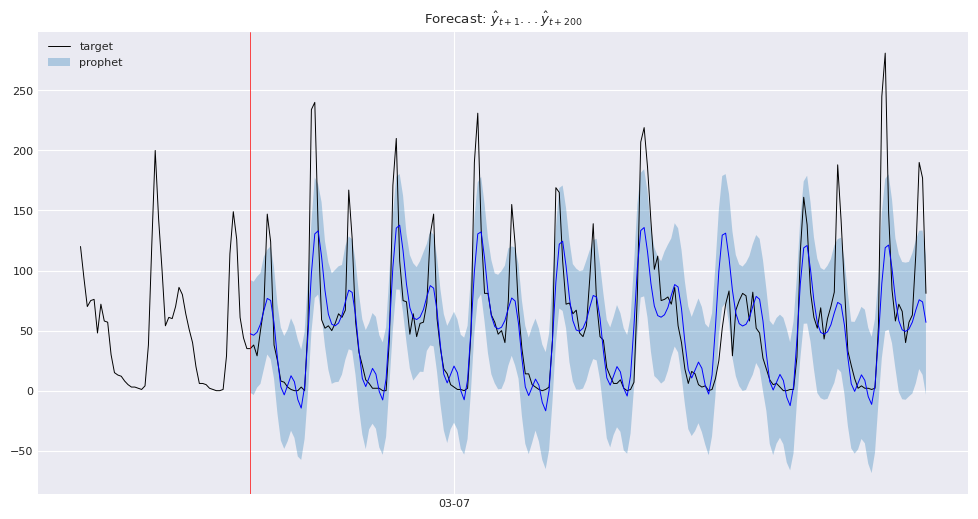

In [35]:
plot_predict(df, start, pred, None, 'Forecast: $\^{y}_{t+1}...\^{y}_{t+200}$')

### An Experiment

#### 5 Variable Extraction
[[To the top]](#contents)

In [70]:
model = Prophet(mcmc_samples=300, 
                holidays=holidays, 
                holidays_prior_scale=0.25, 
                changepoint_prior_scale=0.01, 
                seasonality_mode='multiplicative',
                yearly_seasonality=10,
                weekly_seasonality=True,
                daily_seasonality=True,
                )

for name in ['temp', 'rain', 'sun', 'wind']:
    model.add_regressor(name, prior_scale=0.5, mode='multiplicative')

In [71]:
model_inputs = model.preprocess(df_train)
init_params = model.calculate_initial_params(model_inputs.K)

In [25]:
from dataclasses import asdict

In [26]:
model_inputs = asdict(model_inputs)
init_params = asdict(init_params)

In [27]:
model_inputs.keys()

dict_keys(['T', 'S', 'K', 'tau', 'trend_indicator', 'y', 't', 'cap', 't_change', 's_a', 's_m', 'X', 'sigmas'])

In [28]:
init_params.keys()

dict_keys(['k', 'm', 'delta', 'beta', 'sigma_obs'])

In [29]:
#! pip install -U jax numpyro --target /kaggle/working/site-packages

### 6 Numpyro Model Specification
[[To the top]](#contents)

In [30]:
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive, HMC

In [31]:
def trend_linear(init_coef : float, 
                 init_bias : float,
                 delta : np.ndarray,
                 t : np.ndarray,
                 A : np.ndarray,
                 t_change : np.ndarray,
                 ):
    return (init_coef + A @ delta)*t + (init_bias + A @ (-t_change * delta)) 

def trend_logistic(init_coef : float,
                   init_bias : float,
                   delta : np.ndarray,
                   t : np.ndarray,
                   cap : np.ndarray,
                   A : np.ndarray,
                   t_change,):
    gamma = logistic_gamma(init_coef, init_bias, delta, t_change)
    return cap * sigmoid(init_coef + A @ delta) * (t - (init_bias + A @ gamma))

def sigmoid(x):
    return 1/(1 + np.exp(-x))


def logistic_gamma(init_coef, init_bias, delta, t_change):
    gamma = np.empty(t_change.shape[0])
    k_s = np.c_[init_coef, init_coef + np.cumsum(delta)]
    bias_prev = init_bias
    
    for i in range(t_change.shape[0]):
        gamma[i] = (t_change[i] - bias_prev) * (1 - k_s[i]/k_s[i+1])
        bias_prev += gamma[i]
    return gamma

def pyro_model(X, t, t_change, s_a, s_m, sigmas, y, tau, T, S, K, trend_indicator, cap):
    
    A = (t[:,None] >= t_change[None,:])

    X_sa = X * s_a[None,:]
    X_sm = X * s_m[None,:] 

    init_coef = numpyro.sample('init_coef', dist.Normal(0, 5))
    init_bias = numpyro.sample('init_bias', dist.Normal(0, 5))
    delta = numpyro.sample('delta', dist.Laplace(0,tau)
                        .expand([t_change.shape[0]])
                        .to_event(1))
    sigma_obs = numpyro.sample('sigma_obs', dist.LogNormal(0, 0.5))
    beta = numpyro.sample('beta', dist.Normal(0, sigmas).to_event(1))

    trend = trend_linear(init_coef, init_bias, delta, t, A, t_change)

    numpyro.sample('obs', dist.Normal(X_sa @ beta + trend*(1 + X_sm @ beta), sigma_obs).to_event(1), obs=y)


### 7 Model Fitting
[[To the top]](#contents)

In [32]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [33]:
kernel = NUTS(pyro_model)
mcmc = MCMC(sampler=kernel, num_samples=1000, num_warmup=500)

In [34]:
[ (k,type(v)) for k,v in model_inputs.items()]

[('T', int),
 ('S', int),
 ('K', int),
 ('tau', float),
 ('trend_indicator', int),
 ('y', pandas.core.series.Series),
 ('t', pandas.core.series.Series),
 ('cap', numpy.ndarray),
 ('t_change', numpy.ndarray),
 ('s_a', pandas.core.series.Series),
 ('s_m', pandas.core.series.Series),
 ('X', pandas.core.frame.DataFrame),
 ('sigmas', list)]

In [35]:
for k in ['y', 't', 's_a', 's_m', 'X']:
    model_inputs[k] = model_inputs[k].values
model_inputs['sigmas'] = np.array(model_inputs['sigmas'])

In [36]:
mcmc.run(rng_key_, 
         **model_inputs)

sample: 100%|██████████| 1500/1500 [04:25<00:00,  5.64it/s, 1023 steps of size 2.70e-03. acc. prob=0.93]


In [38]:
params = {'k': mcmc.get_samples()['init_coef'],
          'm': mcmc.get_samples()['init_bias'],
          'sigma_obs': mcmc.get_samples()['sigma_obs'],
          'delta': mcmc.get_samples()['delta'],
          'beta': mcmc.get_samples()['beta'],
          }

In [ ]:
! mkdir -p numpyro_results/res1

In [46]:
for k,v in params.items():
    np.save(f'numpyro_results/res1/{k}.npy', np.array(v))

### 8 Prophet/Numpyro Param Comparison
[[To the top]](#contents)

This comparison is mostly symbolic, since I don't have a sense of scale, i.e. I don't know how large the differences should be to really matter for predictions.

Visual inspection below shows a divergence between param estimates, although some of them stay pretty close.

In [52]:
[ (k, np.mean([model.params[k]])-np.mean([params[k]])) for k in params.keys()]

[('k', 0.01277920162853299),
 ('m', 0.002991952422360205),
 ('sigma_obs', -0.00017954421518642794),
 ('delta', -0.0006551214480275673),
 ('beta', -0.22799586103730812)]

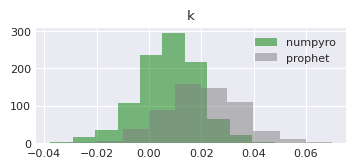

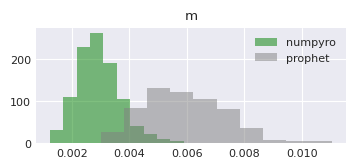

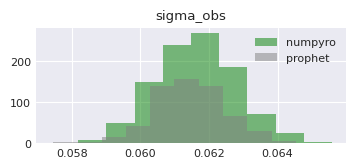

In [53]:
for param in ['k', 'm', 'sigma_obs']:
    fig,ax = plt.subplots(figsize=(4,1.5))
    ax.hist(params[param], color='green', alpha=0.5)
    ax.hist(model.params[param], color='grey', alpha=0.5)
    ax.legend(['numpyro', 'prophet'])
    ax.set_title(param)

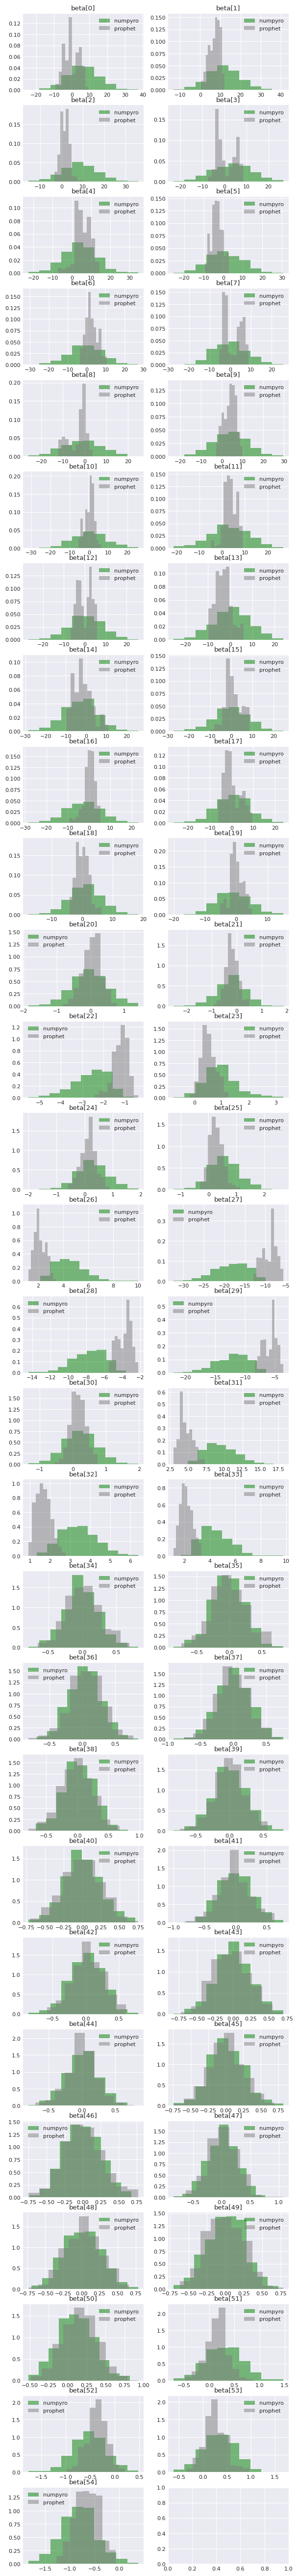

In [64]:
fig,ax = plt.subplots(int(np.ceil(model.params['beta'].shape[1] / 2)), 2,
                      figsize=(7,27*2.5))
for i in range(model.params['beta'].shape[1]):
    row, col = i//2, i%2
    ax[row,col].hist(params['beta'][:,i], density=True, color='green', alpha=0.5)
    ax[row,col].hist(model.params['beta'][:,i], density=True, color='grey', alpha=0.5)
    ax[row,col].legend(['numpyro', 'prophet'])
    ax[row,col].set_title(f'beta[{i}]')

### 9 Forecasts Comparison
[[To the top]](#contents)

Next I plug numpyro estimates back into prophet, load original prophet model and compare their forecasts. I pick three test sets 0, 500 and 1000 timesteps from the last train observation.

In [72]:
model.params = params

In [122]:
train_size = 1500
test_size = 200

In [ ]:
with open(model_ckpt, 'r') as f:
    model2 = model_from_json(f.read())

In [129]:
start = train_size
df_test = df.iloc[start: start + test_size]
pred1 = model.predict(df_test.drop(columns=['y']))
pred2 = model2.predict(df_test.drop(columns=['y']))

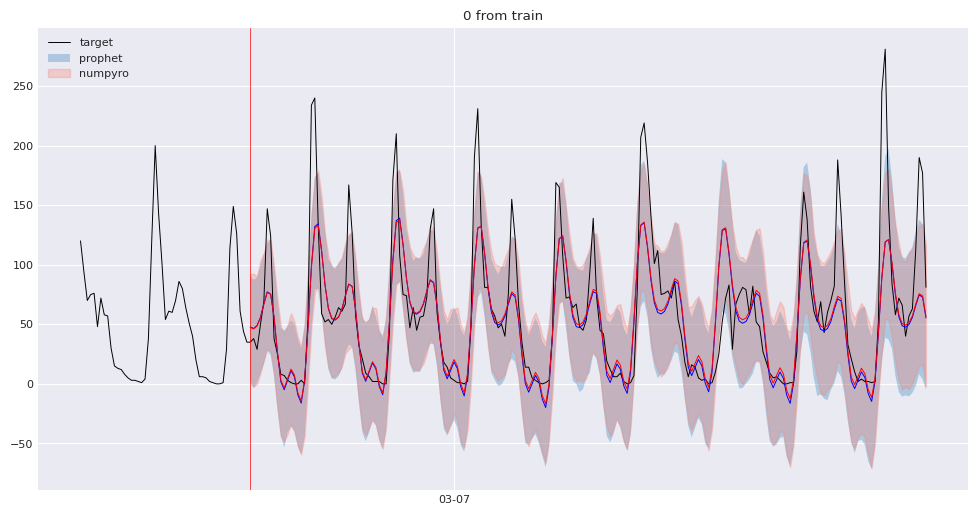

In [130]:
plot_predict(df, start, pred1, pred2, f'{start-train_size} from train')

In [131]:
start = train_size + 500
df_test = df.iloc[start: start + test_size]
pred1 = model.predict(df_test.drop(columns=['y']))
pred2 = model2.predict(df_test.drop(columns=['y']))

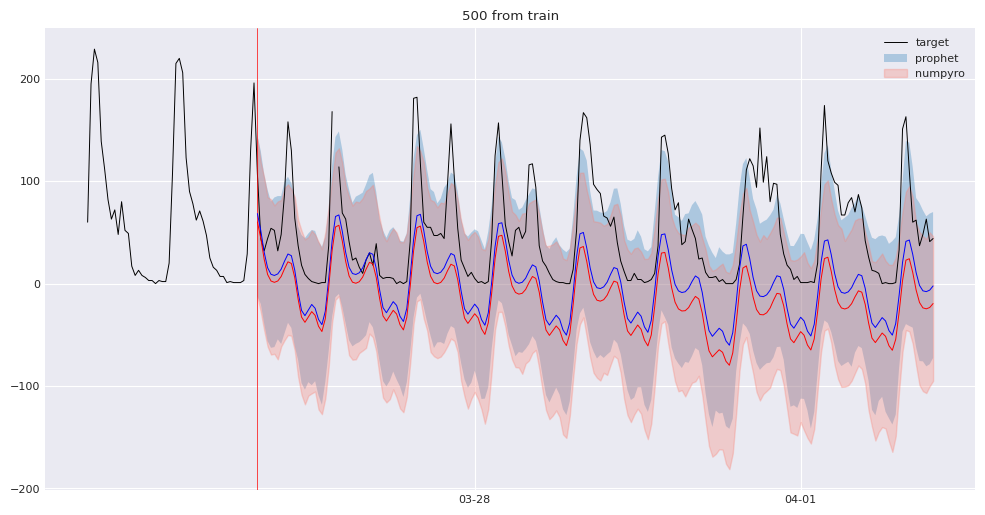

In [132]:
plot_predict(df, start, pred1, pred2, f'{start-train_size} from train')

In [133]:
start = train_size + 1000
df_test = df.iloc[start: start + test_size]
pred1 = model.predict(df_test.drop(columns=['y']))
pred2 = model2.predict(df_test.drop(columns=['y']))

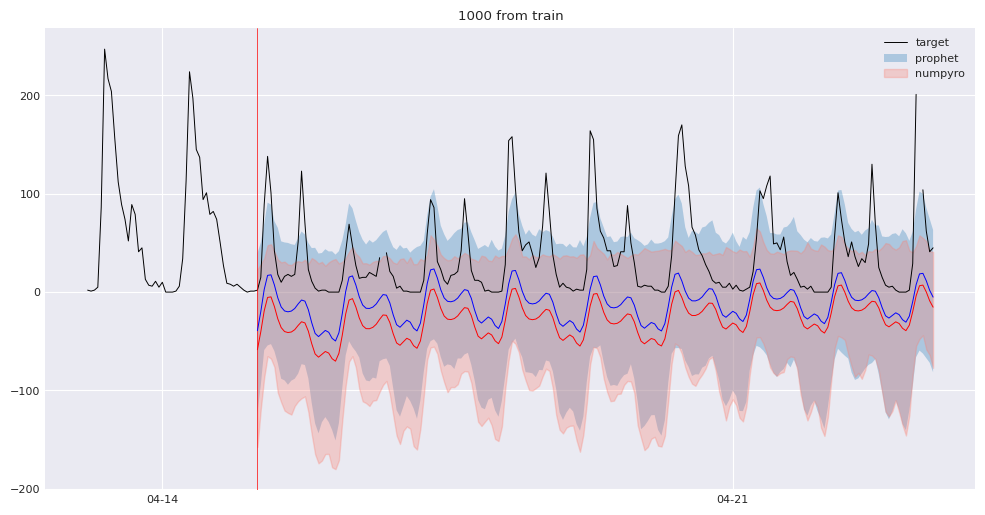

In [134]:
plot_predict(df, start, pred1, pred2, f'{start-train_size} from train')

### Discussion
[[To the top]](#contents)

Forecasting plots imply that 
1. Prediction quality decreases with distance from train set (unsurprisingly)
2. Original and numpyro predictions are very close for the test set, starting right after train set. With distance discrepancy grows

Overall demonstration seems successful in replicating prophet model and thus showing how it works.  